<a href="https://colab.research.google.com/github/RoyElkabetz/TD3_with_PyTorch/blob/main/TD3_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twin Delayed Deep Deterministic Policy Gradient (TD3) Notebook

## Install PyBullet for Physics based environments

In [1]:
! pip install pybullet
! pip install Box2D

     |████████████████████████████████| 90.8 MB 288 bytes/s 
     |████████████████████████████████| 1.3 MB 12.0 MB/s 


In [2]:
! nvidia-smi

Sun Jan 23 19:24:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Clone the Repository

In [3]:
## uncomment only if running from google.colab
# clone the git reposetory
!git clone https://github.com/RoyElkabetz/TD3_with_PyTorch
# add path to .py files for import
import sys
sys.path.insert(1, "/content/TD3_with_PyTorch/src")

Cloning into 'TD3_with_PyTorch'...
remote: Enumerating objects: 231, done.
remote: Counting objects: 100% (231/231), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 231 (delta 103), reused 166 (delta 50), pack-reused 0
Receiving objects: 100% (231/231), 24.37 MiB | 22.71 MiB/s, done.
Resolving deltas: 100% (103/103), done.


## Get imports

In [4]:
import os
import gym
import numpy as np
import pybullet_envs

from utils import plot_learning_curve
from agents import Agent

## Set Agent + Env arguments (similar to the command line API from repo's Readme)

In [5]:
env_name = 'LunarLanderContinuous-v2'
dir = 'tmp'
n_games = 1000


gamma = 0.99
alpha = 0.001
beta = 0.001
fc1_dim = 400
fc2_dim = 300
memory_size = 1000000
batch_size = 100
tau = 0.005
update_period = 2
noise_std = 0.1
noise_clip = 0.5
warmup = 1000
play = False
load_checkpoint = False
gpu_to_cpu = False


## Run TD3


/content/TD3_with_PyTorch/src/agents.py:73: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  state = T.tensor([state], dtype=T.float).to(self.actor.device)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


| Game:      0 | Score:    -121.04 | Best score:       -inf | Avg score    -121.04 | Learning inter:            103 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
| Game:      1 | Score:     -90.02 | Best score:    -121.04 | Avg score    -105.53 | Learning inter:            201 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
| Game:      2 | Score:    -212.08 | Best score:    -105.53 | Avg score    -141.05 | Learning inter:            308 |
| Game:      3 | Score:    -168.51 | Best score:    -105.53 | Avg score    -147.92 | Learning inter:            408 |
| Game:      4 | Score:    -120.06 | Best score:    -105.53 | Avg score    -142.34 | Learning inter:            470 |
| Game:      5 | Score:     -92.98 | Best score:    -105.53 | Avg score    -134.12 | Learning inte

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


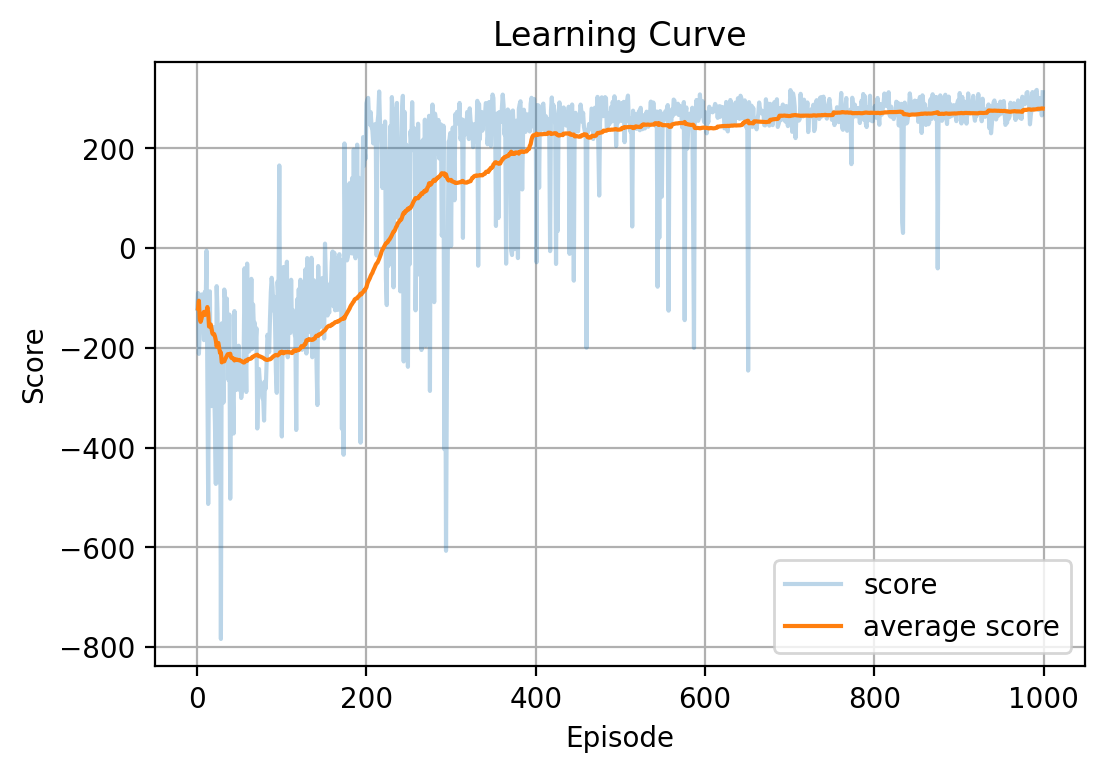

In [6]:
env = gym.make(env_name)
dir_path = os.path.join(dir, env_name)
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

agent = Agent(gamma=gamma, alpha=alpha, beta=beta, state_dims=env.observation_space.shape,
              action_dims=env.action_space.shape, max_action=env.action_space.high[0],
              min_action=env.action_space.low[0], fc1_dim=fc1_dim, fc2_dim=fc2_dim, 
              memory_size=memory_size, batch_size=batch_size, tau=tau, update_period=update_period,
              noise_std=noise_std, warmup=warmup, noise_clip=noise_clip,
              name='TD3_'+env_name, ckpt_dir=dir_path)

scores, avg_scores = [], []
best_score = -np.inf

if play:
    # env.render(mode='human') (cannot render in colab)
    pass

if load_checkpoint:
    agent.load_model(gpu_to_cpu=gpu_to_cpu)

for game in range(n_games):
    observation = env.reset()
    done = False
    score = 0

    while not done:
        if play:
            action = agent.choose_action(observation, add_noise=False)
        else:
            action = agent.choose_action(observation, add_noise=True)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.store_transition(observation, action, reward, observation_, done)
        if not play:
            agent.learn()
        observation = observation_
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    avg_scores.append(avg_score)

    print(f'| Game: {game:6.0f} | Score: {score:10.2f} | Best score: {best_score:10.2f} | '
          f'Avg score {avg_score:10.2f} | Learning inter: {agent.learn_iter:14.0f} |')

    if avg_score > best_score:
        best_score = avg_score
        if not play:
            agent.save_model()
env.close()

if not play:
    plot_learning_curve(scores, agent.full_path)
